In [2]:
#imports
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import h5py
    
import pickle
import corner
import time

from stableemrifisher.fisher import StableEMRIFisher
from stableemrifisher.utils import inner_product, generate_PSD, padding

from few.utils.utility import get_p_at_t
from few.trajectory.inspiral import EMRIInspiral
from few.waveform import GenerateEMRIWaveform
from few.summation.aakwave import AAKSummation
from few.utils.constants import YRSID_SI
from few.utils.constants import SPEED_OF_LIGHT as C_SI

from fastlisaresponse import ResponseWrapper  # Response function 
from lisatools.detector import EqualArmlengthOrbits #ESAOrbits correspond to esa-trailing-orbits.h5
from lisatools.sensitivity import get_sensitivity, A1TDISens, E1TDISens, T1TDISens

from scipy.integrate import quad, nquad
from scipy.interpolate import RegularGridInterpolator, CubicSpline
from scipy.stats import uniform
from scipy.special import factorial
from scipy.optimize import brentq, root

from scipy.stats import multivariate_normal
import warnings

from hierarchical.Hierarchical_Class import Hierarchical, Isource_vac, Isource_loc, Isource_glob, prior_vac, prior_loc, prior_glob, lnM_z_samples, A_n_samples
from hierarchical.JointWave import JointKerrWaveform, JointRelKerrEccFlux
from hierarchical.utility import getz

use_gpu = False

import few

if not use_gpu:
    cfg_set = few.get_config_setter(reset=True)
    cfg_set.enable_backends("cpu")
    cfg_set.set_log_level("info")
else:
    pass #let the backend decide for itself.

startup


In [3]:
T_LISA = 0.1 #LISA observation duration
dt = 10.0 #sampling rate

#waveform class setup
waveform_class = JointKerrWaveform
waveform_class_kwargs = dict(inspiral_kwargs=dict(err=1e-11,),
                             sum_kwargs=dict(pad_output=True),
                             mode_selector_kwargs=dict(mode_selection_threshold=1e-5))

#waveform generator setup
waveform_generator = GenerateEMRIWaveform
waveform_generator_kwargs = dict(return_list=False)

#ResponseWrapper setup
tdi_gen ="1st generation"# "2nd generation"#
order = 20  # interpolation order (should not change the result too much)
tdi_kwargs_esa = dict(
    orbits=EqualArmlengthOrbits(use_gpu=use_gpu), order=order, tdi=tdi_gen, tdi_chan="AE",
)
index_lambda = 8
index_beta = 7
# with longer signals we care less about this
t0 = 10000.0  # throw away on both ends when our orbital information is weird

ResponseWrapper_kwargs = dict(
    #waveform_gen=waveform_generator,
    Tobs = T_LISA,
    dt = dt,
    index_lambda = index_lambda,
    index_beta = index_beta,
    t0 = t0,
    flip_hx = True,
    use_gpu=use_gpu,
    is_ecliptic_latitude=False,
    remove_garbage="zero",
    **tdi_kwargs_esa
)

#noise setup
channels = [A1TDISens, E1TDISens]
noise_model = get_sensitivity
noise_kwargs = [{"sens_fn": channel_i} for channel_i in channels]

In [4]:
sef = StableEMRIFisher(waveform_class=waveform_class, 
                       waveform_class_kwargs=waveform_class_kwargs,
                       waveform_generator=waveform_generator,
                       waveform_generator_kwargs=waveform_generator_kwargs,
                       ResponseWrapper=ResponseWrapper, ResponseWrapper_kwargs=ResponseWrapper_kwargs,
                       noise_model=noise_model, noise_kwargs=noise_kwargs, channels=channels,
                       stats_for_nerds = True, 
                       deriv_type='stable',
                       use_gpu = use_gpu,
                      )

In [5]:
#hypothesis
hypothesis = 'global'# 'vacuum'#, 'local'#, 'global'#

#fixed parameters
T_LISA = 1.0 #observation time, years
dt = 10.0 #sampling interval, seconds

m1 = 1e6 #MBH mass in solar masses (source frame)
m2 = 10.0 #secondary mass in solar masses (source frame)
a = 0.9 #dimensionless spin of the primary
e0 = 0.0 #eccentricity of the CO orbit
x0 = 1.0 #inclination, must be = 1.0 for equatorial model

# initial phases
Phi_phi0 = 0.0 #azimuthal phase
Phi_theta0 = 0.0 #polar phase
Phi_r0 = 0.0 #radial phase

# define the extrinsic parameters
qK = np.pi / 3  # polar spin angle
phiK = np.pi / 4  # azimuthal viewing angle
qS = np.pi / 5  # polar sky angle
phiS = np.pi / 6  # azimuthal viewing angle
dist = 1.0  # distance in Gpc. We'll adjust this later to fix the SNR as 100.0

#BVGR params
if hypothesis == 'vacuum':
    f = 0.0
    Al = 0.0
    nl = 8.0
    Ag = 0.0
    ng = 4.0
    mu_l = [Al,nl]
    
elif hypothesis == 'local':
    f = 0.5
    Al = 1e-4
    nl = 2
    Ag = 0.0
    ng = 4.0
    mu_l = [Al,nl]
    
if hypothesis == 'global':
    f = 0.0
    Al = 0.0
    nl = 8.0
    Ag = 0.9e-9
    ng = 4.0
    mu_l = [Al,nl]
    
K = 5e-3
alpha = 0.2
beta = 0.2
Mstar = 3e6

vec_l = [Al, nl]

print(np.array(vec_l) - np.array(mu_l))
sigma_l = [1e-6,1.0]

Gdot = Ag

Omega_m0 = 0.30
Omega_Lambda0 = 0.70
H0 = 70e6 #m/s/Gpc

z = getz(dist, H0 = H0, Omega_Lambda0=Omega_Lambda0, Omega_m0=Omega_m0)
print(z)
traj_joint = EMRIInspiral(func=JointRelKerrEccFlux)
p0 = get_p_at_t(traj_joint,
                  T_LISA,
                  [m1,
                   m2,
                   a,
                   e0, #e0
                   x0, #Y0
                   Al,
                   nl,
                   Ag,
                   ng, #ng
                  ],
                  ) + 0.5 #buffer

print(p0)

[0. 0.]
0.2036357400140082
7.664346725413963


In [6]:
#calculate the Fisher matrix
filename = f'validation_{hypothesis}'
if not os.path.exists(filename):
    os.mkdir(filename)
    
if hypothesis == 'vacuum':
    param_names = ['m1','dist'] #parameter to vary in FIM calculation
elif hypothesis == 'local':
    param_names = ['m1','dist','Al','nl'] #parameter to vary in FIM calculation
elif hypothesis == 'global':
    param_names = ['m1','dist','Ag'] #parameter to vary in FIM calculation
    
try:
    with h5py.File(f"{filename}/Fisher.h5") as ff:
        Fisher = ff["Fisher"][:]
except:   

    #noise model setup
    channels = [A1TDISens, E1TDISens]
    noise_kwargs = [{"sens_fn": channel_i} for channel_i in channels]

    #delta_range for additional parameters (because the default ranges may not be suitable)
    Ndelta = 12
    delta_range = {
    "Al":np.geomspace(1e-5,1e-10,Ndelta),
    "nl":np.geomspace(1.0,1e-5,Ndelta),
    "Ag":np.geomspace(1e-8,1e-14,Ndelta),
    }

    #setting up kwargs to pass to StableEMRIFishers class
    sef_kwargs = {'param_names': param_names, #params to be varied. m1 is alias for MBH mass in latest version of SEF. !!! DO NOT CHANGE THIS ORDER !!!
                  'T':T_LISA, #LISA observation duration
                  'dt':dt, #sampling rate
                  'der_order':2, #derivative order
                  'Ndelta':8, #number of stable points
                  #'delta_range':delta_range,#custom delta range for additional parameters
                  'stability_plot': False, #True if you wanna plot stability surfaces
                  'plunge_check':False, #no need to check for plunge --- away from plunge ensured from choice of p0.
                  'filename':filename,
                  }

    param_list = [m1, m2, a, p0, e0, x0, dist, qS, phiS, qK, phiK, Phi_phi0, Phi_theta0, Phi_r0]
    add_param_args = {"Al":Al, "nl":nl, "Ag":Ag, "ng":ng} #dict of additional parameters
    emri_kwargs = {'T': T_LISA, 'dt': dt}

    Fisher = sef(*param_list, **sef_kwargs, add_param_args=add_param_args)
    

T:  1.0 dt:  10.0
wave ndim: 2
Computing SNR for parameters: (1000000.0, 10.0, 0.9, 7.664346725413963, 0.0, 1.0, 1.0, 0.6283185307179586, 0.5235987755982988, 1.0471975511965976, 0.7853981633974483, 0.0, 0.0, 0.0, 0.0, 8.0, 9e-10, 4.0)
Waveform Generated. SNR: 16.007697499692956
The optimal source SNR is <= 20. The Fisher approximation may not be valid!
calculating stable deltas...
Gamma_ii for m1: 0.3387355598644731
Gamma_ii for m1: 0.33873555280840045
Gamma_ii for m1: 0.3387355525152559
Gamma_ii for m1: 0.3387355524565361
Gamma_ii for m1: 0.338735552753404
Gamma_ii for m1: 0.338735551274743
Gamma_ii for m1: 0.338735537544798
Gamma_ii for m1: 0.3387355613149417
[np.float64(2.0830623216536663e-08), np.float64(8.654083163157256e-10), np.float64(1.7334999638770265e-10), np.float64(8.764002382481145e-10), np.float64(4.3652371928191236e-09), np.float64(4.053293332685666e-08), np.float64(7.017315688507608e-08)]
2
Gamma_ii for Ag: 4.854619988694262e+19
Gamma_ii for Ag: 4.854619966243448e+19
G

In [25]:
#transform the Fisher from M, dist, to lnM, z

def Jacobian(M,dist,H0,Omega_m0,Omega_Lambda0):
    """ 
    Jacobian for Fisher parameter transformation from [M,dist,Al,nl,Ag] to [lnM,z,Al,nl,Ag]
    Returns a 5x5 diagonal np.ndarray.
    """
    
    #Jacobian = partial old/partial new
    
    delta = dist*1e-5
    del_z_del_dist = ((getz(dist+delta,H0,Omega_m0,Omega_Lambda0)-getz(dist-delta,H0,Omega_m0,Omega_Lambda0))/(2*delta))
    diag = np.diag((M,(del_z_del_dist)**-1,1.0,1.0,1.0))
    
    return diag

J = Jacobian(m1, dist, H0, Omega_m0, Omega_Lambda0)[:len(Fisher),:len(Fisher)]
Fisher_transformed = J.T @ Fisher @ J 

if hypothesis == 'local':
    #Al, nl degenerate. Add prior.
    Fisher_transformed += np.diag([0., 0., 1/1e-6**2, 1/0.01**2])

elif hypothesis == 'global':
    #Ag tight. Add prior.
    Fisher_transformed += np.diag([0., 0., 1/1e-12**2])
    
with h5py.File(f"{filename}/Fisher.h5", "a") as ff:
    if "Fisher_transformed" in ff:
        del ff["Fisher_transformed"]
    ff.create_dataset("Fisher_transformed", data = Fisher_transformed)


In [26]:
np.corrcoef(np.linalg.inv(Fisher_transformed))

array([[ 1.        , -0.66190992,  0.94232221],
       [-0.66190992,  1.        , -0.37284153],
       [ 0.94232221, -0.37284153,  1.        ]])

(<Figure size 2000x2000 with 6 Axes>,
 array([[<Axes: >, <Axes: >, <Axes: >],
        [<Axes: ylabel='dist'>, <Axes: >, <Axes: >],
        [<Axes: xlabel='m1', ylabel='Ag'>, <Axes: xlabel='dist'>,
         <Axes: xlabel='Ag'>]], dtype=object))

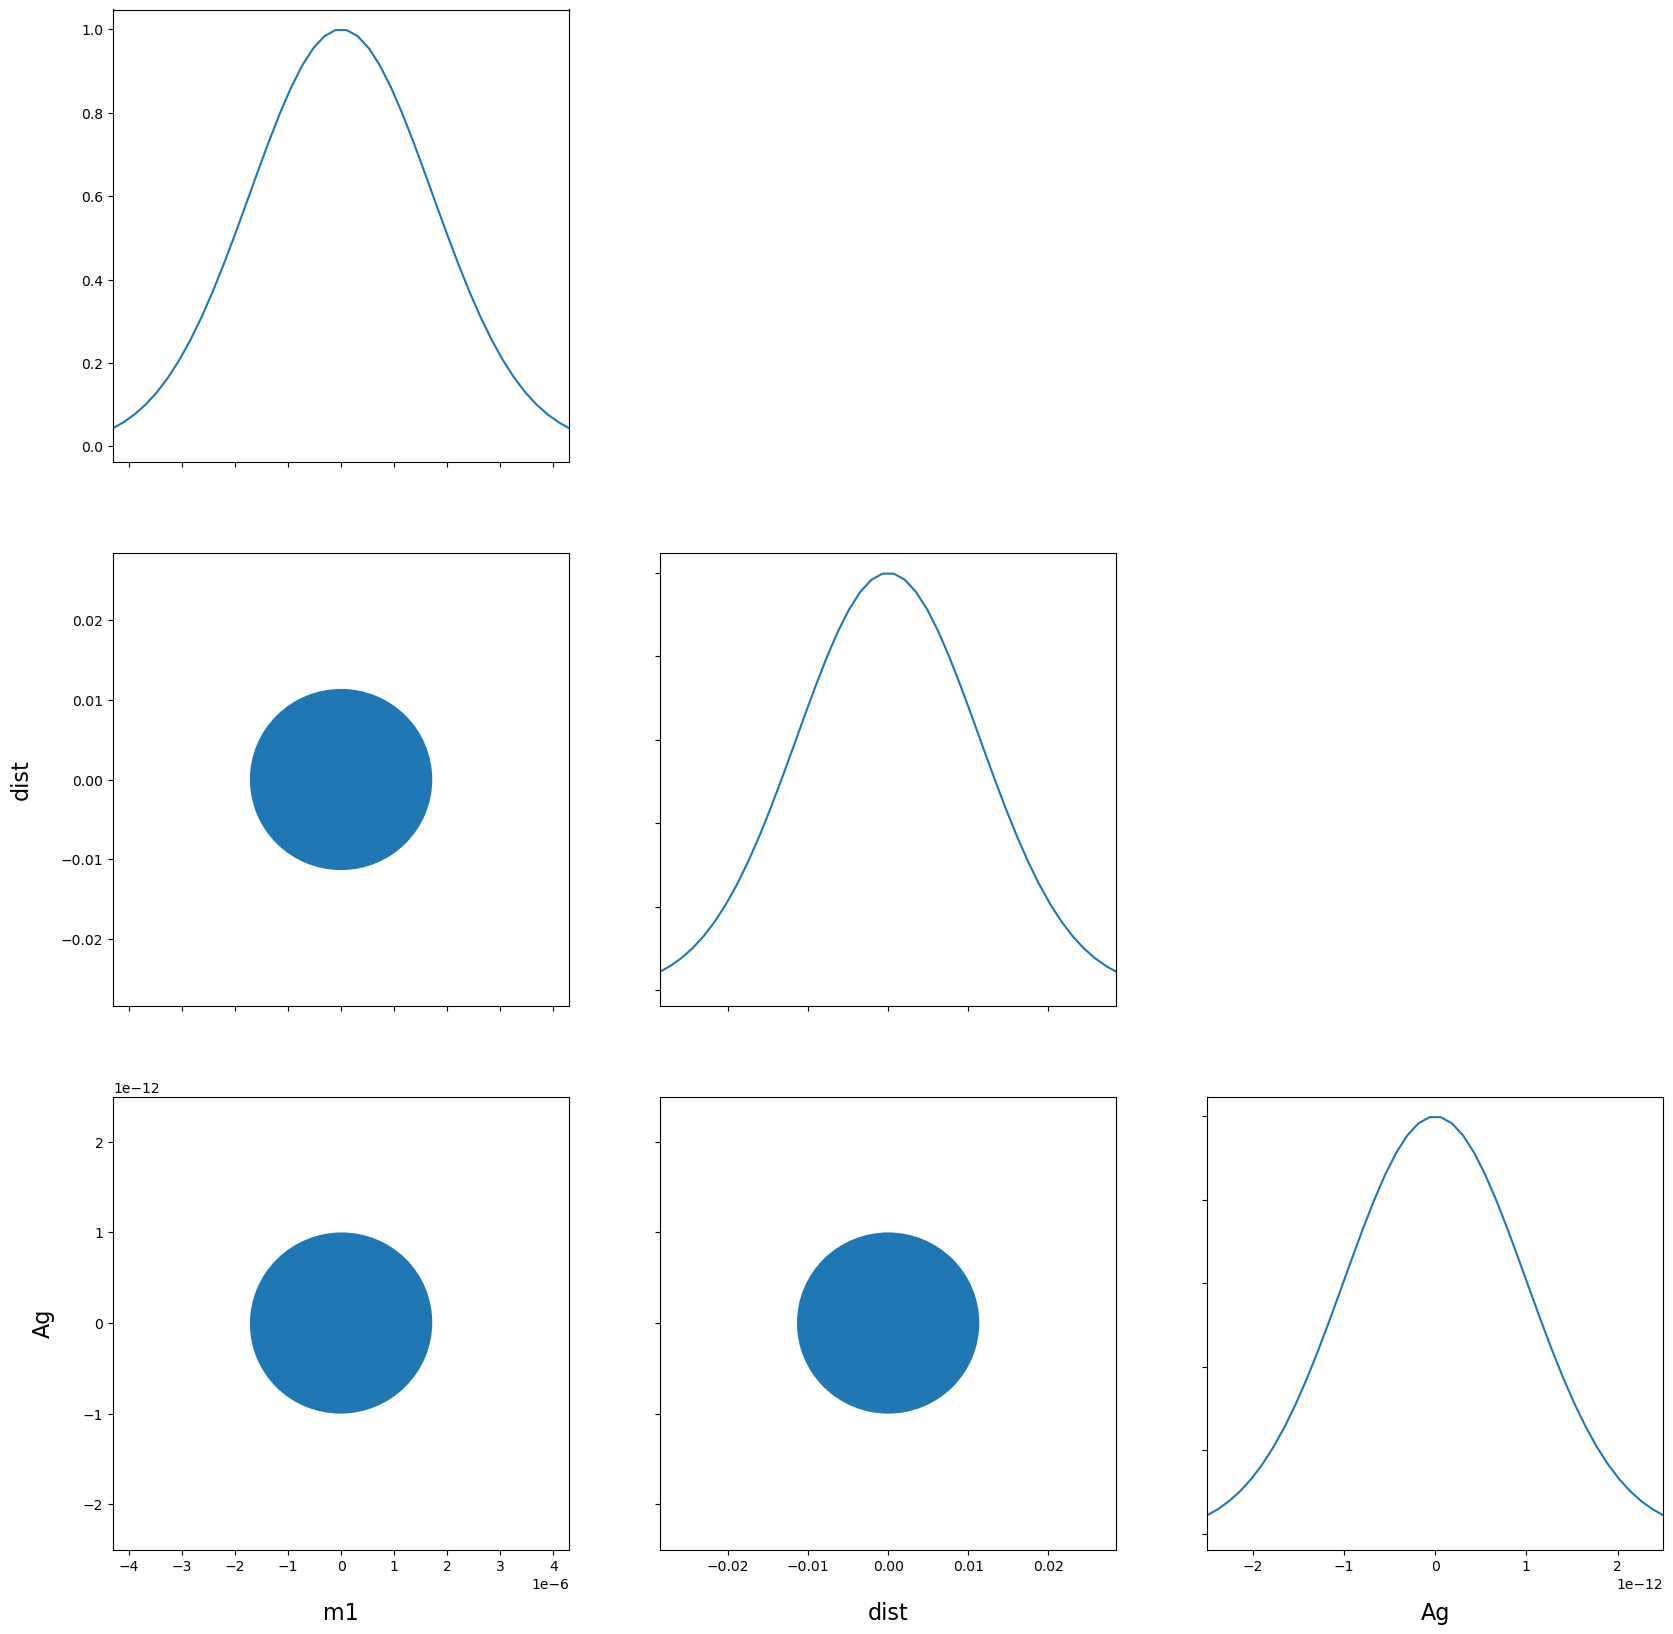

In [27]:
from stableemrifisher.plot import CovEllipsePlot

CovEllipsePlot(np.linalg.inv(Fisher_transformed),param_names=param_names)

In [28]:
#calculate the approximate integral

with h5py.File(f"{filename}/Fisher.h5", "r") as ff:
    Fisher_transformed = ff["Fisher_transformed"][:]

if hypothesis == 'vacuum':
    approx_integral = Isource_vac(np.log(m1), z, K, alpha, beta, Fisher_transformed, H0, Omega_m0, Omega_Lambda0, Mstar = Mstar)
elif hypothesis == 'local':
    approx_integral = Isource_loc(np.log(m1), z, vec_l, K, alpha, beta, f, mu_l, sigma_l, Fisher_transformed, H0, Omega_m0, Omega_Lambda0, Mstar = Mstar)
elif hypothesis == 'global':
    approx_integral = Isource_glob(np.log(m1), z, Ag, K, alpha, beta, Gdot, Fisher_transformed, H0, Omega_m0, Omega_Lambda0, Mstar=Mstar)

print(approx_integral)

[13.81551056  0.20363574]
14440427871.472933


In [29]:
#calculate the exact integral with a numerical approximation

def likelihood(Fisher, theta, theta_hat):
    #return det(Fisher)^(1/2)/(2pi)^(d/2) exp(-1/2 * (theta - theta_hat) dot Fisher dot (theta - theta_hat))
    #Fisher [lnM, z, Al, nl, Ag] or subset thereof
    
    delta = theta - theta_hat
    dim = len(Fisher)
    
    assert len(theta) == len(theta_hat)
    assert len(theta) == dim
    
    expterm = np.dot(np.dot(delta, Fisher), delta)
    
    like = np.exp(-0.5 * expterm) * np.linalg.det(Fisher)**0.5 / ((2 * np.pi) ** (dim/2))
    
    #print('delta: ', delta, 'expterm: ', expterm)
    
    return like

def like_times_prior(Fisher, theta, theta_hat, hypothesis, K, alpha, beta, H0, Omega_m0,Omega_Lambda0, Mstar, f = None, mu_l = None, sigma_l = None, Gdot = None):
    
    like = likelihood(Fisher, theta, theta_hat)
    
    #print('theta: ', theta)
    
    if hypothesis == 'vacuum':
        lnm1, z = theta
        #m1 = np.exp(lnm1)
        
        prior = prior_vac(lnm1, z, K, alpha, beta, H0, Omega_m0,Omega_Lambda0, Mstar)
        
    elif hypothesis == 'local':
        
        lnm1, z, Al, nl = theta
    
        if (Al == 0.0) and (nl == 0.0):
            prior = prior_vac(lnm1, z, K, alpha, beta, H0, Omega_m0,Omega_Lambda0, Mstar) * (1 - f)
        
        else:
            
            vec_l = [Al, nl]
            #m1 = np.exp(lnm1)

            vec_l = np.array(vec_l)
            mu_l = np.array(mu_l)
            sigma_l = np.array(sigma_l)

            Gamma_l = np.diag(1/sigma_l**2)

            #print(f, np.linalg.det(Gamma_l)**(1/2)/(2*np.pi), vec_l-mu_l, Gamma_l)

            prior = prior_vac(lnm1, z, K, alpha, beta, H0, Omega_m0,Omega_Lambda0, Mstar) * prior_loc(vec_l, f, mu_l, sigma_l)
    
    elif hypothesis == 'global':
        lnm1, z, Ag = theta
        #m1 = np.exp(lnm1)

        prior = prior_vac(lnm1, z, K, alpha, beta, H0, Omega_m0,Omega_Lambda0, Mstar) #* prior_glob(Ag, Gdot)
    
    #print(like, prior)
    return like * prior

In [30]:
#monte carlo integral

Ngridsize = 6
Nrange = [int(1e3),int(1e5)]
Ngrid = np.geomspace(Nrange[0],Nrange[1],Ngridsize).astype(int)

Ntrials = 5 #for error bars

with h5py.File(f"{filename}/Fisher.h5", "r") as ff:
    Fisher_transformed = ff["Fisher_transformed"][:] #lnm1, z
    
Fisher_inverse = np.linalg.inv(Fisher_transformed)
std_lnm1 = np.sqrt(Fisher_inverse[0,0])
std_z = np.sqrt(Fisher_inverse[1,1])

lnm1 = np.log(m1)
bounds_vacuum = [
    [(lnm1) - 5 * std_lnm1, (lnm1) + 5 * std_lnm1], #bounds on lnm1
    [z - 5 * std_z, z + 5 * std_z] #bounds on z
]

if hypothesis == 'local':
    
    std_Al = np.sqrt(Fisher_inverse[2,2])
    std_nl = np.sqrt(Fisher_inverse[3,3])
    
    bounds_local = bounds_vacuum + [
        [Al - 5 * std_Al, Al + 5 * std_Al], #bounds on Al
        [nl - 5 * std_nl, nl + 5 * std_nl] #bounds on nl
    ]

if hypothesis == 'global':
    
    std_Ag = np.sqrt(Fisher_inverse[2,2])
    
    bounds_global = bounds_vacuum + [
        [Ag - 5 * std_Ag, Ag + 5 * std_Ag]
    ]

integral_all = []

for _ in tqdm(range(Ntrials)):

    integral_Ntrial = []
        
    for N in tqdm(Ngrid):
        
        integral_exact = 0.0
        
        if hypothesis == 'vacuum':
            
            samples = np.random.uniform(
                                    low=[bounds_vacuum[0][0], bounds_vacuum[1][0]],
                                    high=[bounds_vacuum[0][1], bounds_vacuum[1][1]],
                                    size=(N, 2)
                                )
            
            lnM_samples = samples[:,0]
            z_samples = samples[:,1]
            
            prior_volume = np.prod(np.array(bounds_vacuum)[:,1] - np.array(bounds_vacuum)[:,0])
        
        elif hypothesis == 'local':
            
            samples = np.random.uniform(
                                    low=[bounds_local[0][0], bounds_local[1][0], bounds_local[2][0], bounds_local[3][0]],
                                    high=[bounds_local[0][1], bounds_local[1][1], bounds_local[2][1], bounds_local[3][1]],
                                    size=(N, 4)
                                )
            
            lnM_samples = samples[:,0]
            z_samples = samples[:,1]
            Al_samples = samples[:,2]
            nl_samples = samples[:,3]
            
            prior_volume = np.prod(np.array(bounds_local)[:,1] - np.array(bounds_local)[:,0])
            
        elif hypothesis == 'global':
            
            samples = np.random.uniform(
                                    low=[bounds_vacuum[0][0], bounds_vacuum[1][0]],
                                    high=[bounds_vacuum[0][1], bounds_vacuum[1][1]],
                                    size=(N, 2)
                                )
            
            lnM_samples = samples[:,0]
            z_samples = samples[:,1]
            
            Ag_samples = np.ones(N) * Gdot #integral evaluated at a fixed Ag = Gdot.
                
            prior_volume = np.prod(np.array(bounds_vacuum)[:,1] - np.array(bounds_vacuum)[:,0]) #np.prod(np.array(bounds_global)[:,1] - np.array(bounds_global)[:,0])
            
        for i in range(N):
            
            if hypothesis == 'vacuum':
                
                theta = np.array([lnM_samples[i], z_samples[i]])
                theta_hat = np.array([lnm1, z])
                
                integral_exact += like_times_prior(Fisher_transformed, theta, theta_hat, hypothesis, K, alpha, beta, H0, Omega_m0, Omega_Lambda0, Mstar)
                
            elif hypothesis == 'local':
                
                theta = np.array([lnM_samples[i], z_samples[i], Al_samples[i], nl_samples[i]])
                theta_hat = np.array([lnm1, z, Al, nl])
                
                integral_exact += like_times_prior(Fisher_transformed, theta, theta_hat, hypothesis, K, alpha, beta, H0, Omega_m0, Omega_Lambda0, Mstar, f, mu_l, sigma_l)
    
            elif hypothesis == 'global':
                
                theta = np.array([lnM_samples[i], z_samples[i], Ag_samples[i]])
                theta_hat = np.array([lnm1, z, Ag])
                
                integral_exact += like_times_prior(Fisher_transformed, theta, theta_hat, hypothesis, K, alpha, beta, H0, Omega_m0, Omega_Lambda0, Mstar, Gdot=Gdot)
        
        integral_Ntrial.append(integral_exact * prior_volume / N)

    integral_all.append(np.array(integral_Ntrial))

100%|█████████████████████████████████████████████| 5/5 [00:41<00:00,  8.26s/it]


In [31]:
integral_all/approx_integral

array([[0.92563402, 0.93073416, 1.00305545, 1.01745161, 1.00559055,
        0.98880224],
       [0.97836856, 0.91832558, 1.00789028, 1.00588137, 1.0145776 ,
        0.9946787 ],
       [0.96834829, 1.04701655, 1.02112482, 1.00825652, 1.00456021,
        1.00281806],
       [1.04755271, 1.07096565, 1.01397209, 0.99784233, 1.00016098,
        1.0050117 ],
       [1.0149148 , 1.07799431, 0.99941328, 0.99222399, 0.99282538,
        0.99572294]])

In [32]:
integral_all = np.array(integral_all)
integral_mean = np.mean(integral_all/approx_integral, axis = 0)
integral_errors = np.std(integral_all/approx_integral, axis = 0)

print(integral_mean, integral_errors)

np.savetxt(f'{filename}/integral_mean.txt',integral_mean)
np.savetxt(f'{filename}/integral_error.txt',integral_errors)

[0.98696367 1.00900725 1.00909118 1.00433116 1.00354294 0.99740673] [0.04155486 0.06984641 0.00774811 0.00870226 0.00711751 0.00585547]


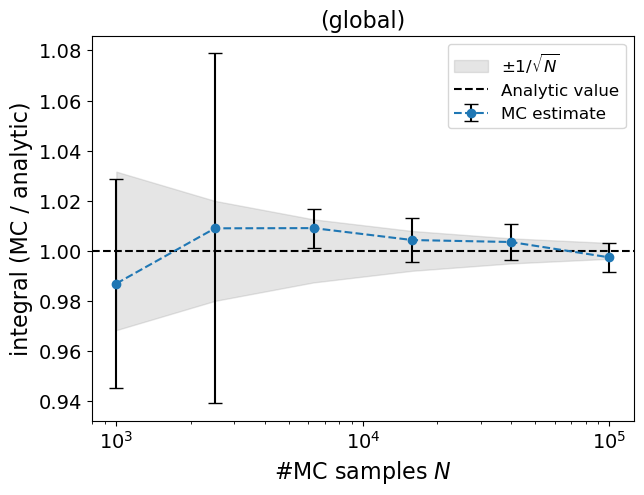

In [33]:
plt.figure(figsize=(7,5))

# Black: actual MC estimate with its empirical error
plt.errorbar(Ngrid, integral_mean, yerr=integral_errors,
             ecolor='k', fmt='o--', capsize=5, label="MC estimate")

# Expected sampling error bands ~ 1/sqrt(N)
theory_error = 1.0/np.sqrt(Ngrid)

# 1-sigma band (light blue)
plt.fill_between(Ngrid, 1 - theory_error, 1 + theory_error,
                 color='grey', alpha=0.2, label=r'$\pm 1/\sqrt{N}$')

plt.xscale('log')
plt.axhline(1.0, color='black', linestyle='--', label="Analytic value")

plt.xlabel('#MC samples $N$', fontsize=16)
plt.ylabel(r'integral (MC / analytic)', fontsize=16)
plt.tick_params(axis='both', labelsize=14)
plt.title(f'({hypothesis})', fontsize=16)
plt.legend(fontsize=12)
plt.savefig(f'{filename}/integral_validation_{hypothesis}.png', dpi=300, bbox_inches='tight')
plt.show()
